In [2]:
import numpy as np
import segyio
import matplotlib.pyplot as plt

Primeiro definimos uma função para ler o arquivo .sgy e obter os levantamentos sísmicos, como o número de traços no volume, o número de amostras por traço e o delta t de amostragem.

In [3]:
def load_segy(fname):
    with segyio.open(fname, ignore_geometry=True) as file:
        # Get basic attributes
        n_traces = file.tracecount
        sample_rate = segyio.tools.dt(file) / 1000
        n_samples = file.samples.size
        time = file.samples
        amplitude = file.trace.raw[:]
        return n_traces, n_samples, sample_rate, time, amplitude

In [4]:
path = './files/SISMICA/'
fname = path+'f3_seismic_with_null_traces.sgy'

n_traces, n_samples, dt_samples, time_axis, data = load_segy(fname)

print(f'numero de traços no volume: {n_traces}')
print(f'numero de amostras por traço: {n_samples}')
print(f'delta t de amostragem (dta): {dt_samples} ms')

numero de traços no volume: 619101
numero de amostras por traço: 463
delta t de amostragem (dta): 4.0 ms


Abaixo, pegamos os dados obtidos pela leitura e transformamos em um array tridimensional com as dimensões obtidas, utilizando a função reshape da biblioteca numpy. Teremos então uma matriz com 651 imagens inline, cada uma com 951 traços, que por sua vez tem 463 amostras.

In [8]:
n_inlines = 651
n_crosslines = 951
print(n_inlines, n_crosslines, n_traces, n_inlines*n_crosslines)
vol = data.reshape((n_inlines, n_crosslines, n_samples))
print(vol.shape)

651 951 619101 619101
(651, 951, 463)


Aqui pegamos diferentes cortes do volume, fixando um dos três níveis da matriz em um valor definido (a metade de cada array).

In [12]:
inline = n_inlines // 2
crossline = n_crosslines // 2
timeline = n_samples // 2

print(inline, crossline, timeline)

325 475 231


In [14]:
inline_section = vol[inline, :, :]
crossline_section = vol[crossline, :, :]
timeline_section = vol[timeline, :, :]

print(inline_section.shape, crossline_section.shape, timeline_section.shape)

(951, 463) (951, 463) (951, 463)


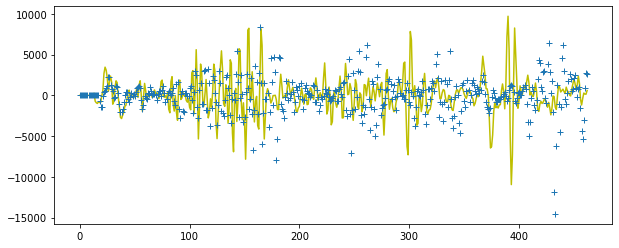

In [15]:
x = np.linspace(0, n_samples-1, n_samples)
trace1 = inline_section[crossline, :]
trace2 = crossline_section[inline, :]
plt.figure(figsize=(10,4))
plt.plot(x, trace1, 'y')
plt.plot(x, trace2, '+')
plt.show()

Definimos uma função que ira receber uma dada imagem ou seção, e irá plota-la ao lado de uma colorbar.

In [26]:
def show_img(img, map_type):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap=map_type, aspect='auto')
    plt.clim((-1, 1))
    plt.colorbar()
    plt.show()

Podemos utilizar esta funcão para visualizar as três seções transversais do nosso volume.

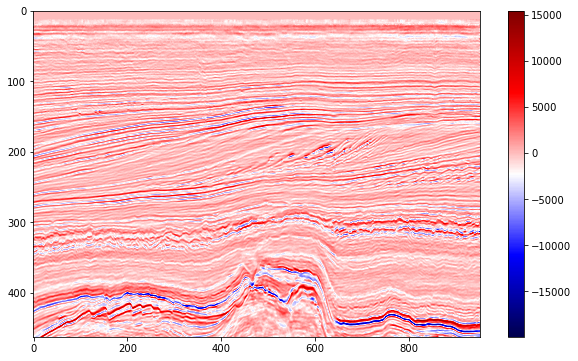

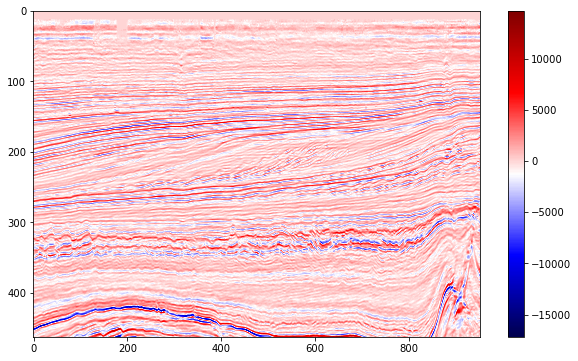

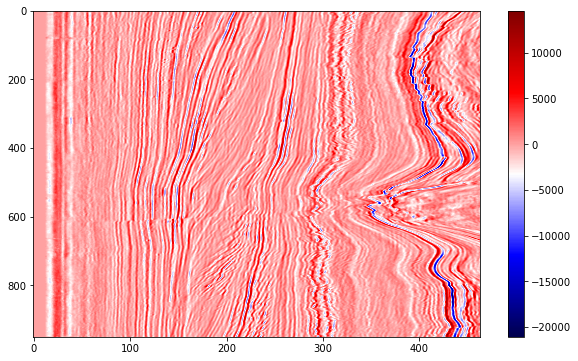

In [20]:
show_img(inline_section.T, 'seismic')
show_img(crossline_section.T, 'seismic')
show_img(timeline_section, 'seismic')

Definimos tambem uma função para plotar um histograma com os valores do volume.

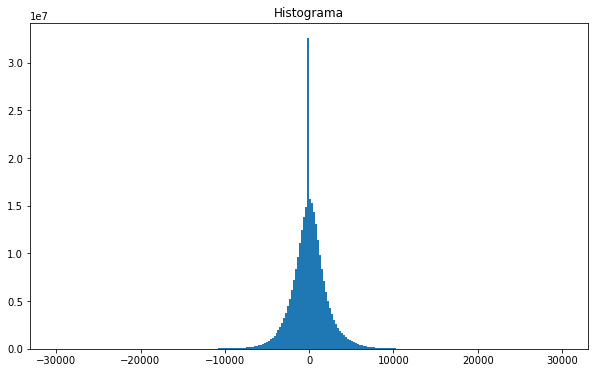

In [22]:
def show_hist(dat):
    plt.figure(figsize=(10,6))
    plt.title("Histograma")
    plt.hist(dat.ravel(), 256)
    plt.show()

show_hist(vol)

Podemos observar no histograma que o intervalo de valores encontrados no volume é extremamente arbitrário, o que pode ser um problema ao fazermos comparações entre volumes diferentes. Para resolver esse problema, podemos normalizar os dados, trazendo-os para um intervalo entre -1 a 1. Na nossa normalização precisamos encontrar uma maneira de desconsiderar outliers nos extremos, que podem afetar a nova distribuição. Fazemos isso da seguinte forma.

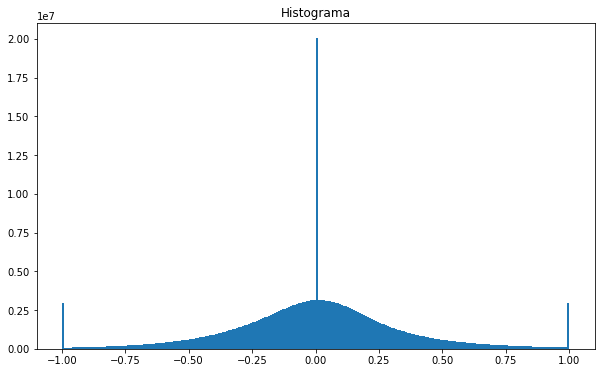

In [24]:
p1, p99 = np.percentile(vol.ravel(), (1,99))
factor = np.amax(np.abs([p1, p99]))
volp = vol/factor
volp[volp>1]=1
volp[volp<-1]=-1
show_hist(volp)

Podemos observar de maneira muito mais clara os máximos e mínimos sísmicos nas imagens das seções.

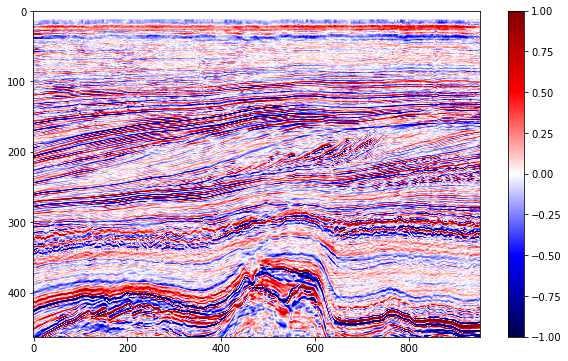

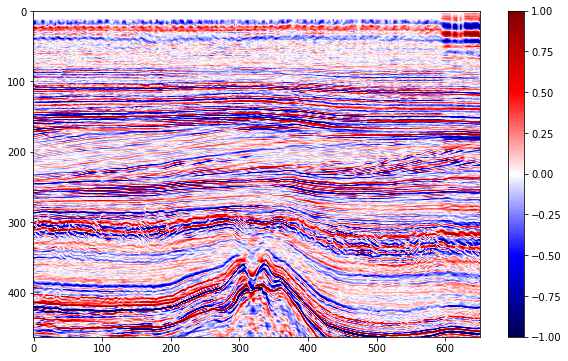

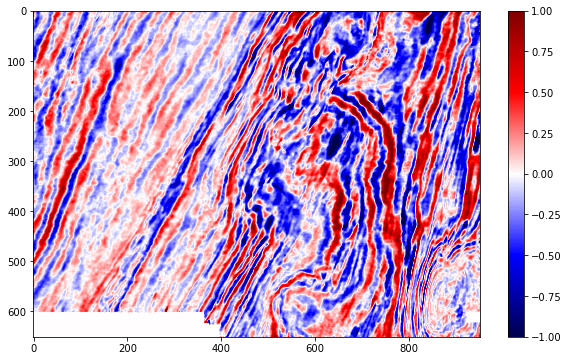

In [29]:
show_img(volp[inline, :, :].T, 'seismic')
show_img(volp[:, crossline, :].T, 'seismic')
show_img(volp[:, :, timeline], 'seismic')

Uma maneira menos custosa de fazer o mesmo procedimento de normalização é utilizar o desvio padrão da amostra. Ao usar 3 vezes o desvio padrão, devido ao fato de ser uma distribuição normal, podemos encapsular mais de 99% de nossos dados, colocando-os em um intervalo entre -1 e 1. 

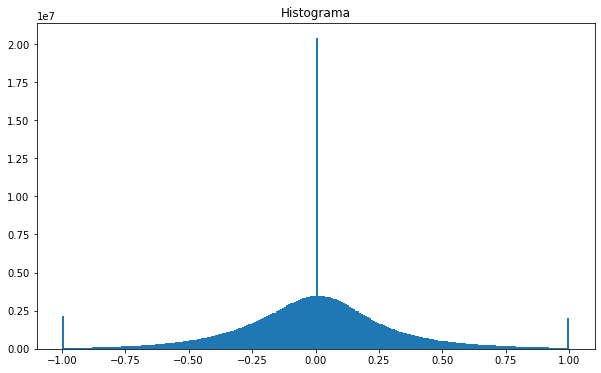

In [31]:
s3 = 3*np.std(vol)
vols = vol/s3
vols[vols>1] = 1
vols[vols<-1] = -1
show_hist(vols)